In [1]:
# подключение библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
output_notebook()

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

Loading BokehJS ...

In [2]:
# чтение исходного файла
data = pd.read_excel('./solar_data_regression_en.xlsx')
df = data.drop(['Transparence'], axis=1)
data.head()

,Hour,Day,Solar_angle,Solar_time,Solar_flow,Сloudiness,Transparence,Temperature,Humidity,Wind_speed,Generation
0,12,269,-2.216887,14.379906,787.433789,0.0,75.996296,18.00,30.0,6.944444,10206.00
1,13,269,-2.216887,15.379906,644.730161,0.0,73.982707,18.00,30.0,6.944444,8143.80
2,14,269,-2.216887,16.379906,455.486706,0.0,69.487206,18.00,30.0,6.944444,5238.24
3,15,269,-2.216887,17.379906,232.600054,0.0,59.414224,17.50,31.0,6.527778,1984.08
4,16,269,-2.216887,18.379906,56.946636,0.0,0.000000,16.75,32.5,5.555556,141.96


In [3]:
data

,Hour,Day,Solar_angle,Solar_time,Solar_flow,Сloudiness,Transparence,Temperature,Humidity,Wind_speed,Generation
0,12,269,-2.216887,14.379906,787.433789,0.000,75.996296,18.00,30.0,6.944444,10206.00
1,13,269,-2.216887,15.379906,644.730161,0.000,73.982707,18.00,30.0,6.944444,8143.80
2,14,269,-2.216887,16.379906,455.486706,0.000,69.487206,18.00,30.0,6.944444,5238.24
3,15,269,-2.216887,17.379906,232.600054,0.000,59.414224,17.50,31.0,6.527778,1984.08
4,16,269,-2.216887,18.379906,56.946636,0.000,0.000000,16.75,32.5,5.555556,141.96
...,...,...,...,...,...,...,...,...,...,...,...
2321,5,1,-23.011637,7.185965,0.000000,95.000,0.000000,1.00,100.0,1.944444,0.00
2322,6,1,-23.011637,8.185965,43.283738,81.250,4.926609,0.50,100.0,3.055556,10.08
2323,7,1,-23.011637,9.185965,178.221903,88.125,10.213490,0.00,100.0,3.055556,168.84
2324,8,1,-23.011637,10.185965,334.983290,97.500,13.879266,0.00,100.0,3.472222,544.32


In [4]:
# проверка типов данных
data.dtypes

Hour              int64
Day               int64
Solar_angle     float64
Solar_time      float64
Solar_flow      float64
Сloudiness      float64
Transparence    float64
Temperature     float64
Humidity        float64
Wind_speed      float64
Generation      float64
dtype: object

<Axes: >

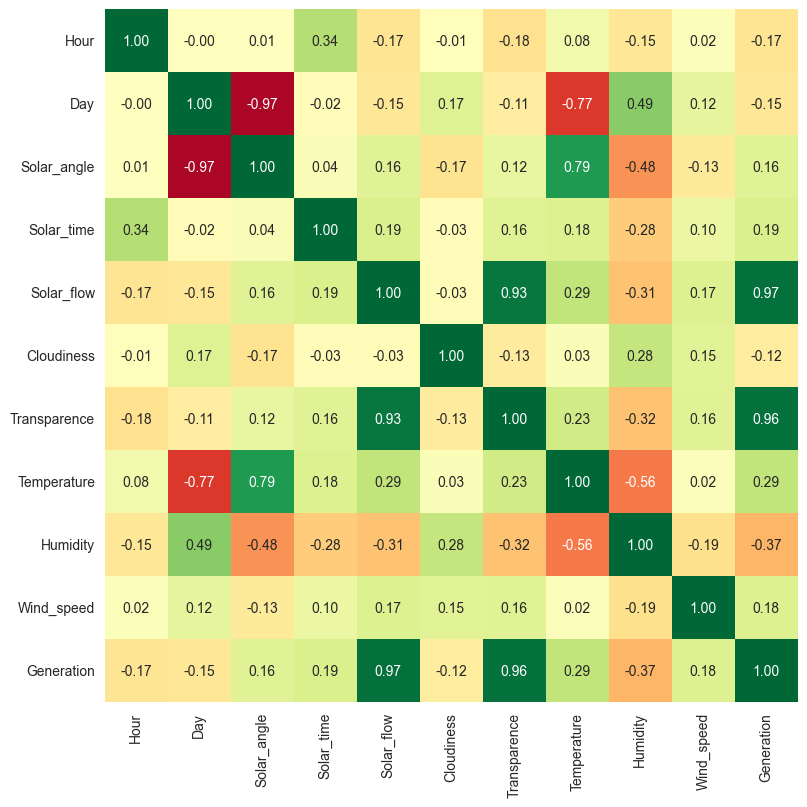

In [5]:
# визуализация коэффициентов корреляции
plt.figure(figsize=(9, 9))
sns.heatmap(data.corr(method = 'spearman'), cmap = 'RdYlGn', vmax = 1, vmin = -1, square=True, annot=True, fmt = '.2f', cbar=False)

In [6]:
# визуализация временного ряда исходных данных
p = figure()

p.scatter(np.arange(len(data.index)), data['Generation'].values, line_width = 2, color = 'green', legend_label = 'G')
p.line(np.arange(len(data.index)), data['Generation'].values, line_width = 2, color = 'green', legend_label = 'G')
show(p)

In [7]:
# разделение выборки, 80 % на обучение и валидацию, 20 % на тестирование
train_split_point = int(len(data.index) * 0.8)

X_trainval = data.iloc[: train_split_point, : -1]
y_trainval = data.iloc[ : train_split_point, -1]

X_test = data.iloc[train_split_point : , : -1]
y_test = data.iloc[train_split_point : , -1]

print(data.shape, X_trainval.shape, X_test.shape)

(2326, 11) (1860, 10) (466, 10)


In [8]:
# обучение модели в режиме кросс-валидации
def create_evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
    print('RMSE on validation sets:', scores * -1, 'kWh')
    print('Mean RMSE on validation sets::', int(scores.mean() * -1), 'kWh')
    model.fit(X, y)
    print('Mean RMSE on train set:', int(calc_rmse(model, X, y)), 'kWh')
    return model

In [9]:
def calc_rmse(model, X, y):
    return np.sqrt(metrics.mean_squared_error(model.predict(X), y))

In [10]:
# функция для визуализации прогноза
def visualize(model, X, y):
    p = figure()

    times = np.arange(y.shape[0])
    p.scatter(times, y, line_width = 2, color = 'green', legend_label = 'G')
    p.line(times, y, line_width = 2, color = 'green', legend_label = 'G')
    p.scatter(times, model.predict(X), line_width = 2, color = 'red', legend_label = 'P')
    p.line(times, model.predict(X), line_width = 2, color = 'red', legend_label = 'P')

    show(p)

In [11]:
#model_dt = DecisionTreeRegressor(max_depth=3) # инициализация модели

#model_rf = RandomForestRegressor(n_estimators=50, max_depth=5)

#model_ab = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=50)

#model_xgb = xgb.XGBRegressor(n_estimators=50, max_depth=5)

model = create_evaluate_model(SVR(kernel='linear'), X_trainval, y_trainval) # обучение и валидация модели
visualize(model, X_trainval, y_trainval) # расчет метрик точности и визуализация


RMSE on validation sets: [2306.10043365 1450.00351525  944.53600361 1048.43175404 1271.33820588] kWh
Mean RMSE on validation sets:: 1404 kWh
Mean RMSE on train set: 1355 kWh


In [12]:
visualize(model, X_test, y_test)